In [1]:
import cv2
import numpy as np
import glob
import os
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
from scipy.misc import imread
import tensorflow as tf

from functools import partial
from collections import deque
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

from src.detection import Detection
from src.misc import visualise, draw_bboxes, draw_labeled_bboxes, draw_heatmap, apply_threshold, nonMaxSuppression

# Third Party code + model location
from src.thirdParty.ssd import SSD300
from src.thirdParty.ssd_utils import BBoxUtility

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (25, 25)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

Using TensorFlow backend.


## Input

In [2]:
testExp = 'test_images/test*.jpg'
testImages = [imread(path) for path in glob.glob(testExp)]

# Weights can be downloaded here
weightsUrl = 'https://drive.google.com/uc?export=download&confirm=Ebvg&id=1v-unYTorm4v4hL1uOKgYbxVzcv3oCEId'
# Weights on file path
weightsFileName = 'weights.hdf5'

del testExp

## SSD

In [3]:
def loadModel(weightsFileName):
    # Trained classes + shape
    shape = (300, 300, 3)
    classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
                   'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
                   'Dog', 'Horse', 'Motorbike', 'Person', 'Pottedplant',
                   'Sheep', 'Sofa', 'Train', 'Tvmonitor']
    num_classes = len(classes) + 1
    bbox_helper = BBoxUtility(num_classes)
    
    model = SSD300(input_shape=shape, num_classes=num_classes)
    model.load_weights(weightsFileName)
    
    return model, bbox_helper, classes

In [4]:
def extract_bboxes(results, frame):
    h, w = frame.shape[:2]
    ret = []
    for row in results:
        _, _, x_min, y_min, x_max, y_max = row        
        box = (int(round(x_min * w)), int(round(y_min * h)),
                   int(round(x_max * w)), int(round(y_max * h)))
        ret.append(box)
    return np.array(ret)

In [5]:
def processImage(frame, model, helper, filt=None, min_confidence=0.2):
    inputs = []
    
    shape = model.layers[0].output_shape[1:3]
    img = image.img_to_array(cv2.resize(frame, shape))
    inputs.append(img.copy())
    
    inputs = preprocess_input(np.array(inputs))
    preds = model.predict(inputs, batch_size=1, verbose=0)
    results = helper.detection_out(preds, confidence_threshold=min_confidence)[0]
    
    if filt:
        results = [r for r in results if int(r[0]) in filt]

    return results

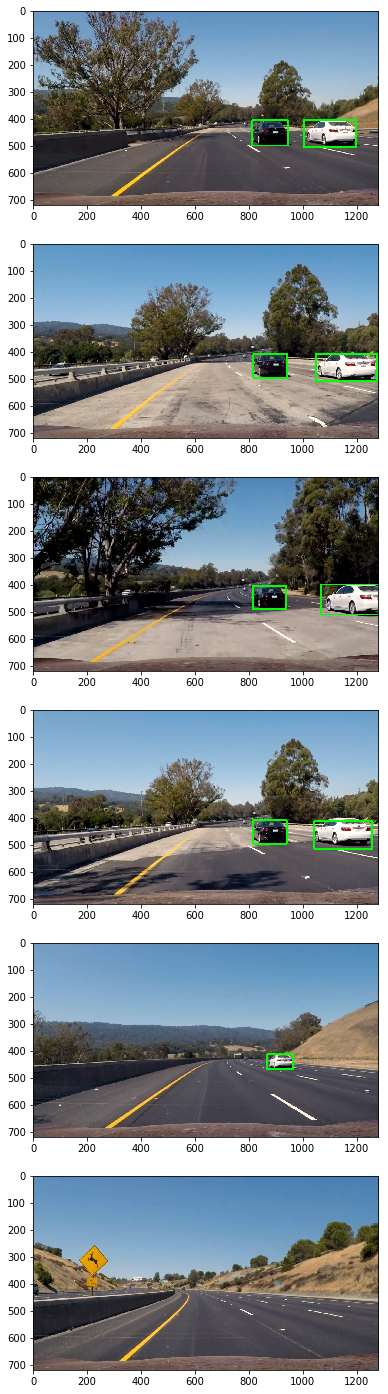

In [7]:
def dummyScope(imgs):
    model, helper, classes = loadModel(weightsFileName)
    
    forVis = []
    for img in imgs:
        results = processImage(img, model, helper, filt=[7])
        bboxes = extract_bboxes(results, img)
        ret = draw_bboxes(img, bboxes)
        forVis.append(ret)
    visualise(plt.figure(), len(imgs), 1, forVis)
    
dummyScope(testImages)
del dummyScope

## Video

In [ ]:
def processFrame(frame, procIm, detections):
    # Mark detections inactive
    for detection in detections:
        detection.setFrameInactive()
    
    # Process image in isolation
    results = procIm(frame)
    boxes = extract_bboxes(results, frame)
        
    # Compare against current vehicles
    for box in boxes:
        match = None
        for detection in detections:
            if (not detection.canIgnore()) and detection.calcIOU(box) > 0.8:
                match = detection
                break
        
        if match is None:
            detections.append(Detection(box))
        else:
            match.setFrameActive()
            match.updateBox(box)
    
    toShow = []
    for detection in detections:
        if detection.isCar():
            toShow.append(detection.estimate)
    
    img = draw_bboxes(frame, toShow)
    
    return img

In [ ]:
fin, fout = 'project_video.mp4', 'ssd_out2.mp4'
#fin = 'test_video.mp4'

detections = []
model, helper, classes = loadModel(modelUrl)
func = partial(processImage, model = model, helper = helper, 
               filt=[7], min_confidence=0.2)
procF = partial(processFrame, procIm = func, detections = detections)

# Video processing functionality    
video_input = VideoFileClip(fin)
print('FPS: {}'.format(video_input.fps))
#processed_video = video_input.fl_image(procF).subclip(12.0, 20.0)
processed_video = video_input.fl_image(procF)
%time processed_video.write_videofile(fout, audio=False)